In [171]:
# Imports
import pandas as pd # Data manipulation
import numpy as np # Algebric operations
import matplotlib.pyplot as plt # Plots
from sklearn.ensemble import RandomForestRegressor
import sys
sys.path.append('../')
from utils import hit_count

In [172]:
# Read the data
data = pd.read_csv('../../Data/all_stocks_5yr.csv')
' '.join(np.unique(data['Name']))

'A AAL AAP AAPL ABBV ABC ABT ACN ADBE ADI ADM ADP ADS ADSK AEE AEP AES AET AFL AGN AIG AIV AIZ AJG AKAM ALB ALGN ALK ALL ALLE ALXN AMAT AMD AME AMG AMGN AMP AMZN ANDV ANSS ANTM AON AOS APA APC APD APH ARE ARNC ATVI AVB AVGO AVY AWK AXP AYI AZO BA BAC BAX BBT BBY BCR BDX BEN BF.B BHF BHGE BIIB BK BLK BLL BMY BRK.B BSX BWA BXP C CA CAG CAH CAT CB CBG CBOE CBS CCI CCL CELG CERN CF CFG CHD CHK CHRW CHTR CI CINF CL CLX CMA CMCSA CME CMG CMI CMS CNC CNP COF COG COH COL COO COP COST COTY CPB CRM CSCO CSRA CSX CTAS CTL CTSH CTXS CVS CVX CXO D DAL DD DE DFS DG DGX DHI DHR DIS DISCA DISCK DISH DLPH DLR DLTR DOV DOW DPS DRE DRI DTE DUK DVA DVN DXC EA EBAY ECL ED EFX EIX EL EMN EMR EOG EQIX EQR EQT ES ESRX ESS ETFC ETN ETR EVHC EW EXC EXPD EXPE EXR F FAST FB FBHS FCX FDX FE FFIV FIS FISV FITB FL FLIR FLR FLS FMC FOX FOXA FRT FTI FTV GD GE GGP GILD GIS GLW GM GOOG GOOGL GPC GPN GPS GRMN GS GT GWW HAL HAS HBAN HBI HCA HCN HCP HD HES HIG HLT HOG HOLX HON HP HPE HPQ HRB HRL HRS HSIC HST HSY HUM IBM IC

#### Moving average

In [196]:
class TrendDescriptor:
    def __init__(self, init_buffer):
        self._buffer = init_buffer

    def next(self):
        return np.mean(self._buffer)

    def update(self, z):
        self._buffer.pop(0)
        self._buffer.append(z)

#### Selecting a data serie for analysis (3M)

In [197]:
series = data[data.loc[:, 'Name'] == 'MMM'].loc[:, 'Close'].values.tolist()
series[1:10]

[92.3, 92.54, 93.74, 94.24, 93.89, 93.21, 92.68, 91.98, 92.83]

#### Training and testing splits

In [198]:
train_test_split_perc = 0.9
split_point = round(train_test_split_perc * len(series))
split_point

1132

#### Visualizing original time series and its trend

In [205]:
s_window_size = 15
trend_d = TrendDescriptor(series[:s_window_size])
smoothed = series[:s_window_size]
for i in range(s_window_size + 1, split_point):
    smoothed.append(trend_d.next())
    if i < split_point:
        trend_d.update(series[i])

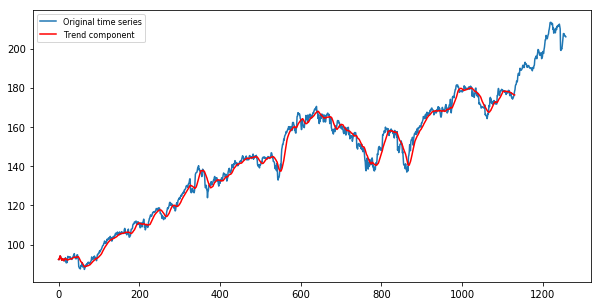

In [206]:
plt.figure(figsize=(10,5))
plt.plot(series, label='Original time series')
plt.plot(smoothed, c='r', label='Trend component')
plt.legend(fontsize=8)
plt.show()

#### Let's see how data looks like after subtracting the trend component

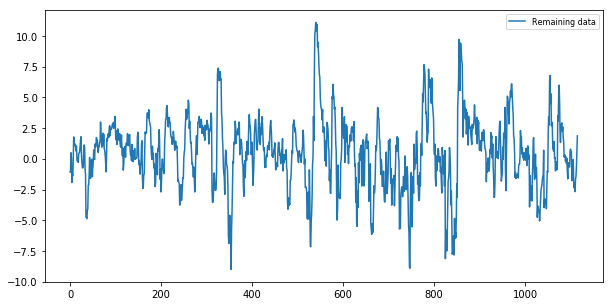

In [207]:
res_series = [a - b for a, b in zip(series[:split_point], smoothed)]
plt.figure(figsize=(10,5))
plt.plot(res_series[s_window_size:], label='Remaining data')
plt.legend(fontsize=8)
plt.show()

In [208]:
res_series = res_series[s_window_size:]

In [209]:
class Windownizer:
    def __init__(self, window_size=5):
        self.window_size = window_size

    def train_builder(self, series):
        samples_dict = {}
        self._series = series
        for z in range(self.window_size, len(self._series)):
            samples_dict[z] = self._series[(z-self.window_size):(z+1)]
        return pd.DataFrame.from_dict(samples_dict, orient='index')
    
    def next_sample(self):
        return np.array(self._series[-self.window_size:])[None, :]
    
    def update_series(self, z):
        self._series.append(z)

In [222]:
windw = Windownizer(5)
training = windw.train_builder(res_series)
training.head(5)

,0,1,2,3,4,5
5,-1.086000,-0.972667,0.492000,0.013333,-1.932000,-1.227333
6,-0.972667,0.492000,0.013333,-1.932000,-1.227333,-1.382000
7,0.492000,0.013333,-1.932000,-1.227333,-1.382000,-0.055333
8,0.013333,-1.932000,-1.227333,-1.382000,-0.055333,1.778000
9,-1.932000,-1.227333,-1.382000,-0.055333,1.778000,1.458000


In [223]:
rf_res = RandomForestRegressor(n_estimators=100)
rf_res.fit(training.iloc[:, :-1], training.iloc[:, -1])

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

#### Getting new predictions

In [224]:
preds = []
for t in range(split_point, len(series)):
    s_aux = trend_d.next()
    trend_d.update(series[t])
    pred = s_aux + rf_res.predict(windw.next_sample())
    preds.append(pred)
    windw.update_series(series[t] - trend_d.next())
    

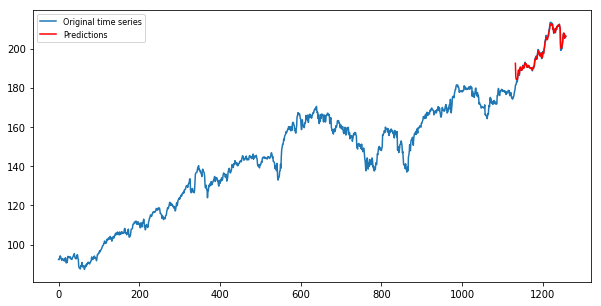

In [225]:
plt.figure(figsize=(10,5))
plt.plot(series, label='Original time series')
plt.plot([t for t in range(split_point, len(series))], preds, c='r', label='Predictions')
plt.legend(fontsize=8)
plt.show()

#### Zooming in

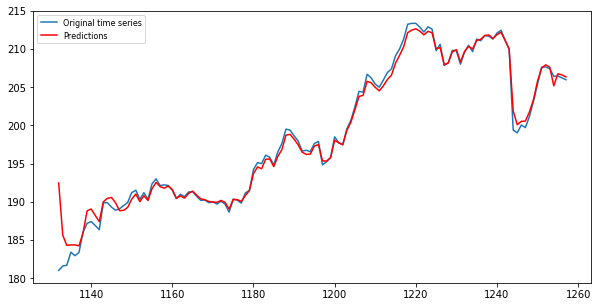

In [226]:
plt.figure(figsize=(10,5))
plt.plot([t for t in range(split_point, len(series))], series[split_point:], label='Original time series')
plt.plot([t for t in range(split_point, len(series))], preds, c='r', label='Predictions')
plt.legend(fontsize=8)
plt.show()

### MSE

In [227]:
def MSE(obs, pred):
    return np.sum([(a - b) ** 2 for a, b in zip(obs, pred)])/len(obs)

In [228]:
MSE(series[split_point:], preds)

1.5886641357853355